In [1]:
# Suppress warnings (This is only to keep the notebook pretty. You might want to comment the below two lines)
import warnings

warnings.filterwarnings("ignore")

# - Import statements
import torch
import samna

import time
import seaborn
from tqdm.auto import tqdm
import numpy as np
import torch.nn as nn
from torchvision import datasets
import sinabs
from sinabs.from_torch import from_model
from sinabs.backend.dynapcnn import io
from sinabs.backend.dynapcnn import DynapcnnNetwork
from sinabs.backend.dynapcnn.chip_factory import ChipFactory
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager

assert samna.__version__ >= '0.21.8', f"samna version {samna.__version__} is too low for this experiment"

In [2]:
devkit = samna.device.open_device("Speck2eDevKit:0")

# get the handle of the stop-watch of the devkit
stop_watch = devkit.get_stop_watch()

# get the handle of the power monitor of the devkit
power_monitor = devkit.get_power_monitor()

# create samna node for power reading
power_source_node = power_monitor.get_source_node()
power_buffer_node = samna.BasicSinkNode_unifirm_modules_events_measurement()

# init graph
samna_graph = samna.graph.EventFilterGraph()

# build graph
samna_graph.sequential([power_source_node, power_buffer_node])
time.sleep(0.5)

In [3]:
measure_time = 5.0  # seconds
sample_rate = 100.0  # Hz

# start samna graph
samna_graph.start()

# start the stop-watch of devkit, then each output data has a proper timestamp
stop_watch.set_enable_value(True)

# clear buffer
power_buffer_node.get_events()

# start monitor, we need pass a sample rate argument to the power monitor
power_monitor.start_auto_power_measurement(sample_rate)

# sleep the procees to wait for the measurement time up
time.sleep(measure_time)

# stop monitor
power_monitor.stop_auto_power_measurement()

# stop samna graph
samna_graph.stop()

# get power-measurement data
power_events = power_buffer_node.get_events()

# time * sample rate * number of power tracks
estimated_number_of_data = measure_time * sample_rate * 5
print(f"estimated number of collect data: {estimated_number_of_data}")

print(f"number of collected data: {len(power_events)}")

estimated number of collect data: 2500.0
number of collected data: 2500


In [4]:
num_power_tracks = 5

# init dict for storing data of each power track
power_each_track = dict()
event_count_each_track = dict()

# check whether timestamp is correct
timestamp_all_zero = True

# loop through all collected power events and get data
for evt in power_events:

    if evt.timestamp != 0:
        timestamp_all_zero = False
    
    p_track_id = evt.channel
    tmp_power = power_each_track.get(p_track_id, 0) + evt.value
    tmp_count = event_count_each_track.get(p_track_id, 0) + 1
    
    power_each_track.update({p_track_id: tmp_power})
    event_count_each_track.update({p_track_id: tmp_count})

# average power and current of each track
for p_track_id in range(num_power_tracks):
    
    # average power in microwatt
    avg_power = power_each_track[p_track_id] / event_count_each_track[p_track_id] * 1e6
    # calculate current
    if p_track_id == 0:
        current = avg_power / 2.5 
    else:
        current = avg_power / 1.2
        
    print(f'track{p_track_id}: {avg_power}uW, {current}uA')

track0: 54.2665100097656uW, 21.70660400390624uA
track1: 60.908203124999474uW, 50.75683593749957uA
track2: 268.00990513392844uW, 223.34158761160705uA
track3: 362.76750837053606uW, 302.30625697544673uA
track4: 573.0688476562493uW, 477.55737304687443uA


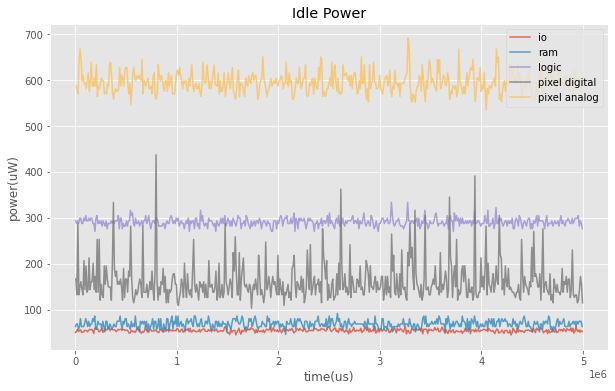

In [11]:
if timestamp_all_zero:
    
    print("timestamps are all zeros, can't plot power vs. time, you might need to update the firmware!")
    
else:
    plt.rcParams['figure.figsize']=(10, 6)
    plt.rcParams['axes.facecolor']='white'
    # plot the output neuron index vs. time
    plt.style.use('ggplot')
    fig, ax = plt.subplots()
    p_track_name = ["io", "ram", "logic", "pixel digital", "pixel analog"]
    for p_track_id in range(num_power_tracks):
        x = [each.timestamp for each in power_events if each.channel == p_track_id]
        y = [each.value * 1e6 for each in power_events if each.channel == p_track_id]
        plt.plot(x, y, label=p_track_name[p_track_id], alpha=0.8)
        
    ax.set_xlabel("time(us)")
    ax.set_ylabel("power(uW)")
    ax.set_title("Idle Power")
    ax.legend(loc="upper right", fontsize=10)
    # ax.set_facecolor('grey')
    ax.set_alpha(1)
    plt.show()
    

In [12]:
# close devkit after experiment finished
samna.device.close_device(devkit)